### NBA Data Analysis

In this project, we explore a dataset containing detailed information on NBA players, including their personal details, team affiliations, physical attributes, and performance statistics. The dataset includes both current and historical players, covering aspects such as draft information, points scored, rebounds, assists, positions, and career timelines.

### Project setup

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

# Settings for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:
# Load dataset
path = '/content/PlayerIndex_nba_stats.csv'
df = pd.read_csv(path)

# Data obtained from: https://www.kaggle.com/datasets/yagizfiratt/nba-players-database/data

In [7]:
# Basic info
print("Shape:", df.shape)
df.head()

Shape: (5025, 26)


,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,...,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
0,76001,Abdelnaby,Alaa,alaa-abdelnaby,1610612757,blazers,0,Portland,Trail Blazers,POR,...,1990.0,1.0,25.0,NaN,5.7,3.3,0.3,Career,1990,1994
1,76002,Abdul-Aziz,Zaid,zaid-abdul-aziz,1610612745,rockets,0,Houston,Rockets,HOU,...,1968.0,1.0,5.0,NaN,9.0,8.0,1.2,Career,1968,1977
2,76003,Abdul-Jabbar,Kareem,kareem-abdul-jabbar,1610612747,lakers,0,Los Angeles,Lakers,LAL,...,1969.0,1.0,1.0,NaN,24.6,11.2,3.6,Career,1969,1988
3,51,Abdul-Rauf,Mahmoud,mahmoud-abdul-rauf,1610612743,nuggets,0,Denver,Nuggets,DEN,...,1990.0,1.0,3.0,NaN,14.6,1.9,3.5,Career,1990,2000
4,1505,Abdul-Wahad,Tariq,tariq-abdul-wahad,1610612758,kings,0,Sacramento,Kings,SAC,...,1997.0,1.0,11.0,NaN,7.8,3.3,1.1,Career,1997,2003


###Data cleaning

In [8]:
# Check missing values
df.isnull().sum()

,0
PERSON_ID,0
PLAYER_LAST_NAME,0
PLAYER_FIRST_NAME,1
PLAYER_SLUG,0
TEAM_ID,0
TEAM_SLUG,266
IS_DEFUNCT,0
TEAM_CITY,0
TEAM_NAME,0
TEAM_ABBREVIATION,0


In [9]:
# Drop rows where key player info is missing
df.dropna(subset=['PLAYER_FIRST_NAME', 'PLAYER_LAST_NAME', 'TEAM_NAME', 'POSITION'], inplace=True)

# Fill or clean numerical columns
df['HEIGHT'] = df['HEIGHT'].replace(' ', np.nan)
df['HEIGHT'] = df['HEIGHT'].fillna("Unknown")

# Convert stats to numeric
df['PTS'] = pd.to_numeric(df['PTS'], errors='coerce')
df['REB'] = pd.to_numeric(df['REB'], errors='coerce')
df['AST'] = pd.to_numeric(df['AST'], errors='coerce')

# Drop rows with no stat data
df.dropna(subset=['PTS', 'REB', 'AST'], inplace=True)

###Data analysis

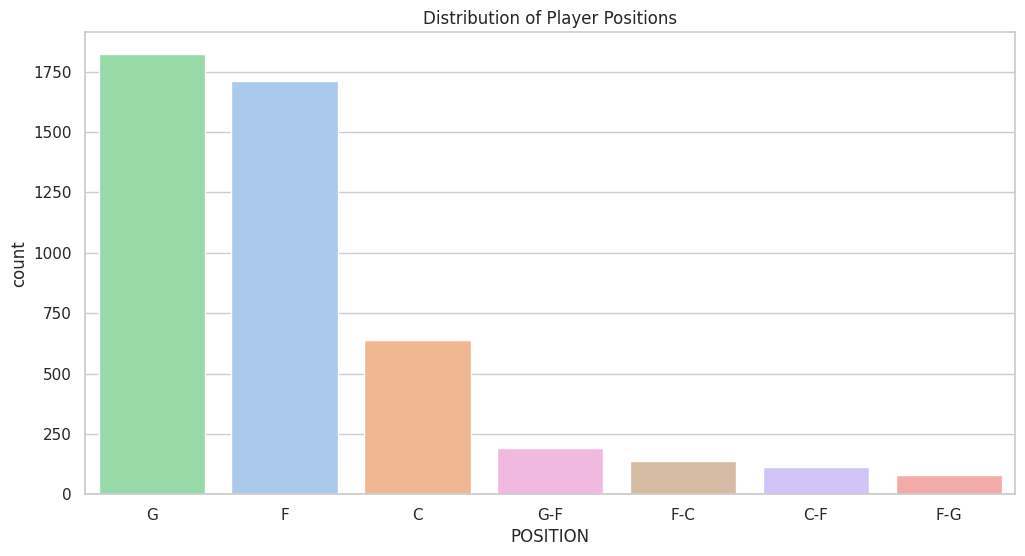

In [10]:
# Number of players per position
sns.countplot(data=df, x='POSITION', order=df['POSITION'].value_counts().index, hue='POSITION', palette='pastel', legend=False)
plt.title("Distribution of Player Positions")
plt.show()

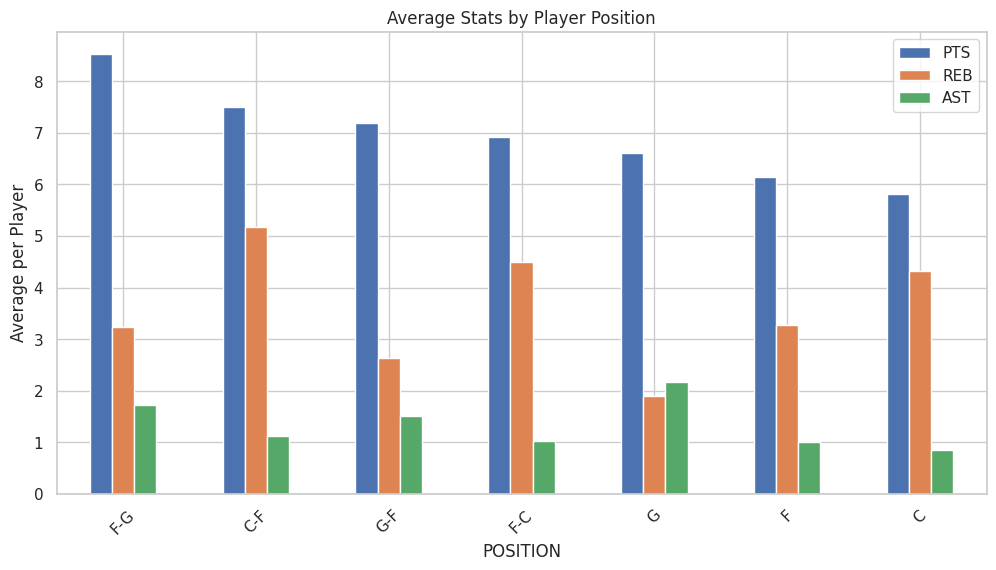

In [11]:
# Average stats (PTS, REB, AST) by player per position

df.groupby('POSITION')[['PTS', 'REB', 'AST']].mean().sort_values('PTS', ascending=False).plot(kind='bar')
plt.title("Average Stats by Player Position")
plt.ylabel("Average per Player")
plt.xticks(rotation=45)
plt.show()

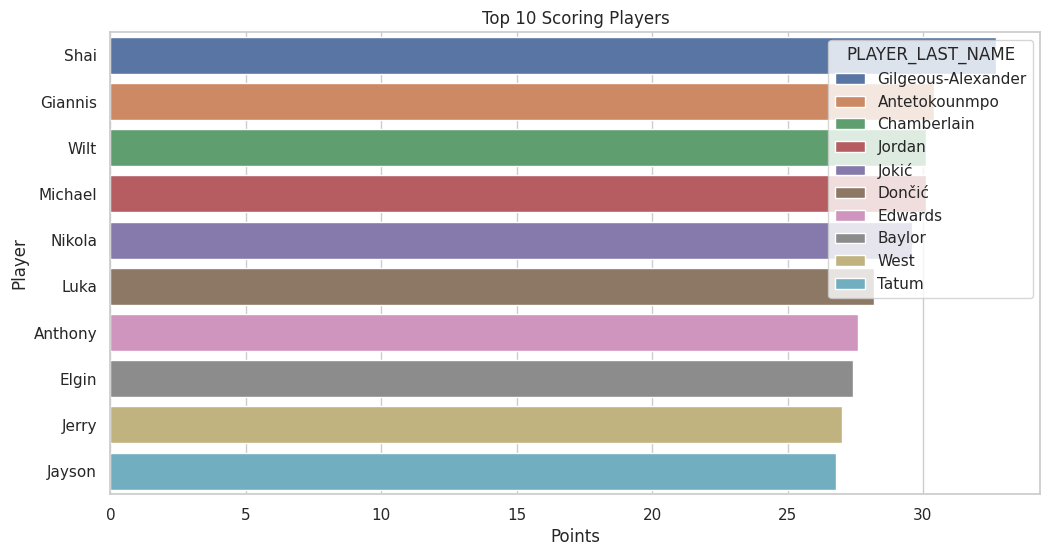

In [12]:
# Top 10 NBA scoring players by AVG

top_pts = df.sort_values(by='PTS', ascending=False).head(10)
sns.barplot(x='PTS', y='PLAYER_FIRST_NAME', data=top_pts, hue='PLAYER_LAST_NAME', dodge=False)
plt.title("Top 10 Scoring Players")
plt.xlabel("Points")
plt.ylabel("Player")
plt.show()

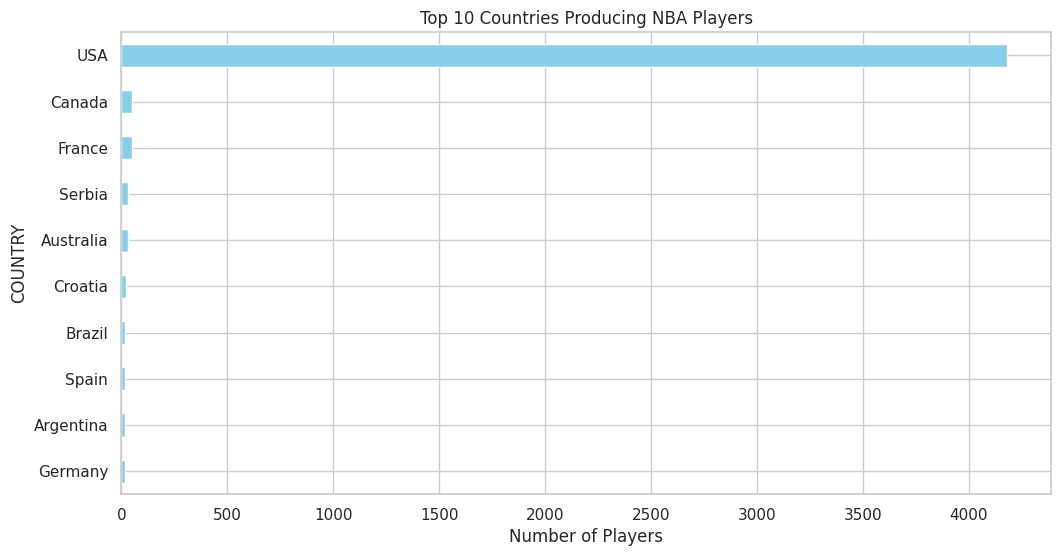

In [13]:
# Top 10 players' contries

df['COUNTRY'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Countries Producing NBA Players")
plt.xlabel("Number of Players")
plt.gca().invert_yaxis()
plt.show()

In [14]:
# Number of undrafted NBA players

undrafted = df[df['DRAFT_YEAR'].isnull()]
print("Number of undrafted players:", len(undrafted))

Number of undrafted players: 1078


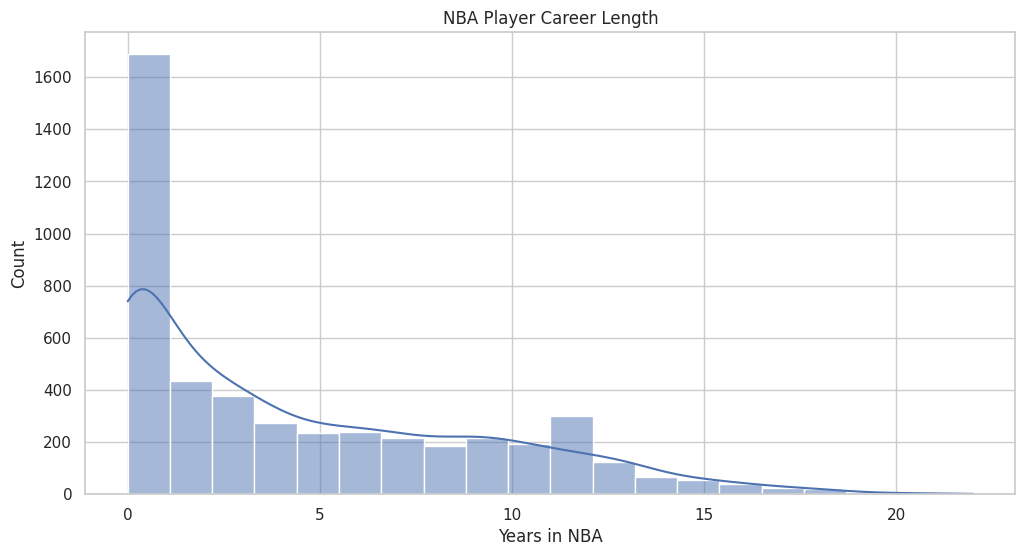

In [15]:
# Players' career length

df['CAREER_LENGTH'] = df['TO_YEAR'] - df['FROM_YEAR']
sns.histplot(df['CAREER_LENGTH'], bins=20, kde=True)
plt.title("NBA Player Career Length")
plt.xlabel("Years in NBA")
plt.show()

###Data analysis using SQL

In [16]:
# Top 10 NBA scoring players

duckdb.query("""
SELECT PLAYER_FIRST_NAME || ' ' || PLAYER_LAST_NAME AS player,
       TEAM_NAME,
       MAX(PTS) AS points
FROM df
GROUP BY player, TEAM_NAME
ORDER BY points DESC
LIMIT 10
""").to_df()

,player,TEAM_NAME,points
0,Shai Gilgeous-Alexander,Thunder,32.7
1,Giannis Antetokounmpo,Bucks,30.4
2,Michael Jordan,Bulls,30.1
3,Wilt Chamberlain,Warriors,30.1
4,Nikola Jokić,Nuggets,29.6
5,Luka Dončić,Lakers,28.2
6,Anthony Edwards,Timberwolves,27.6
7,Elgin Baylor,Lakers,27.4
8,Jerry West,Lakers,27.0
9,Jayson Tatum,Celtics,26.8


In [17]:
# Top-scoring NBA positions

duckdb.query("""
SELECT POSITION,
       ROUND(AVG(PTS), 1) AS avg_pts,
       ROUND(AVG(REB), 1) AS avg_reb,
       ROUND(AVG(AST), 1) AS avg_ast
FROM df
GROUP BY POSITION
ORDER BY avg_pts DESC
""").to_df()

,POSITION,avg_pts,avg_reb,avg_ast
0,F-G,8.5,3.2,1.7
1,C-F,7.5,5.2,1.1
2,G-F,7.2,2.6,1.5
3,F-C,6.9,4.5,1.0
4,G,6.6,1.9,2.2
5,F,6.1,3.3,1.0
6,C,5.8,4.3,0.8


#Conclusion



*	Guards are the most common position in the NBA.
*	Forward-Guards (F-G) lead in scoring, Center-Forwards (C-F) dominate in rebounds, and Guards (G) record the most assists.
*	Shai Gilgeous-Alexander is the NBA’s top scorer, averaging 32.7 points per game.
*	The United States produces by far the most NBA players.
*	NBA careers range from 0 to 20 years, with most players having careers that last 0 to 10 years.
*	Players at the F-G position average the highest scoring output, with 8.5 points per game.



